<h1>
<center>Navid Bahadoran</center>
</h1>
<h1>
<center>Homework 5, due October 13th, 11:59pm</center>
</h1>

<h2>
<center>October 5, 2023</center>
</h2>


1. Implement the FSA variable selection method for linear models and binary classification
with the logistic loss, as described in page 4 of the $FSA$ slides. Use the
parameters $s = 0.0001, \mu = 200, N_{iter} = 300$. Take special care to `normalize each
column` of the $X$ matrix to have zero mean and variance 1 and to use the same mean
and standard deviation that you used for normalizing the train set also for normalizing
the test set.

**a) Using the Gisette data, train a $FSA$ classifier on the training set, starting with
$\beta(0) = 0$ to select $k \in {10, 30, 100, 300, 500}$ features. Plot the training loss
vs iteration number for $k = 30$. Report in a table the misclassification errors
on the training and test set for the models obtained for all these $k$. Plot the
misclassification error on the training and test set vs $k$. Also plot the train and
test ROC curves of the obtained model with 100 features. (4 points)**

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
gisette_train_X_path = Path(r'D:\Pycharm\Courses\STA5635\HW5\Gisette\gisette_train.data')
gisette_train_label_path = Path(r'D:\Pycharm\Courses\STA5635\HW5\Gisette\gisette_train.labels')
gisette_test_X_path = Path(r'D:\Pycharm\Courses\STA5635\HW5\Gisette\gisette_valid.data')
gisette_test_label_path = Path(r'D:\Pycharm\Courses\STA5635\HW5\Gisette\gisette_valid.labels')

In [3]:
gisette_train_X = pd.read_csv(gisette_train_X_path, delimiter=' ', header=None).drop(5000,axis=1)
gisette_train_label=pd.read_csv(gisette_train_label_path, delimiter=' ', header=None)
gisette_test_X = pd.read_csv(gisette_test_X_path, delimiter=' ', header=None).drop(5000,axis=1)
gisette_test_label=pd.read_csv(gisette_test_label_path, delimiter=' ', header=None)

In [4]:
# normalize the variables of the training set to have zero mean and standard deviation 1 
# Also removing the samples with std=0 which degenerate our scaling
sx=np.std(gisette_train_X,axis=0)
filt=sx>0
gisette_train_X=gisette_train_X.to_numpy()[:,filt]
gisette_test_X=gisette_test_X.to_numpy()[:,filt]
mx=np.mean(gisette_train_X,axis=0)
sx=np.std(gisette_train_X,axis=0)
gisette_train_X=(gisette_train_X-mx)/sx
gisette_test_X=(gisette_test_X-mx)/sx

In [5]:
gisette_train_X=np.c_[np.ones(gisette_train_X.shape[0]),gisette_train_X]
gisette_test_X=np.c_[np.ones(gisette_test_X.shape[0]),gisette_test_X]

In [6]:
# convert the labels from-1,1 to 0,1
gisette_train_label.loc[gisette_train_label[0]==-1] = 0
gisette_test_label.loc[gisette_test_label[0]==-1] = 0

In [7]:
gisette_train_label=gisette_train_label.to_numpy()
gisette_test_label=gisette_test_label.to_numpy()

In [8]:
learning_rate=1
k=[10,30,100,300,500]
s=0.0001
n_sample=len(gisette_train_X)
p=len(gisette_train_X[0])
n_iteration=300
w=np.zeros((p,1))
mu=200

In [9]:
var=gisette_train_X
w=np.zeros((p,1))
loss_list=[]
for i in range(n_iteration):
    XWT = var@w
    exp = np.exp(XWT)
    prob = exp/(1+exp)
    gradient = var.T@(gisette_train_label-prob)
    log_likelihood = (gisette_train_label.T@XWT)[0][0]- np.log(1+exp).sum()
    loss=-log_likelihood/n_sample+(s*(w.T@w)[0][0])
    loss_list.append(loss)
    w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
    M=k[1]+(p-k[1])*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
    maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
    w=w[maxarg,:]
    var=var[:,maxarg]

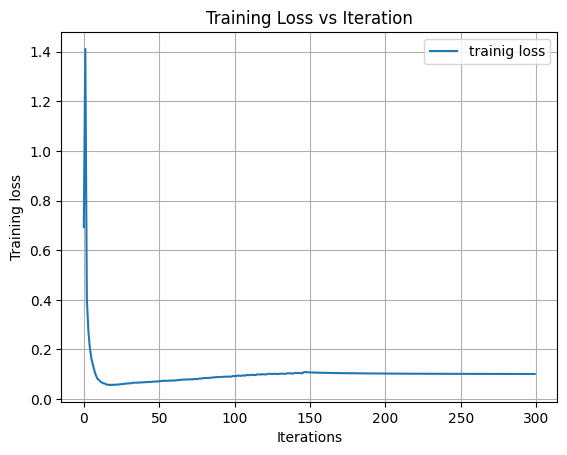

In [10]:
plt.plot(range(n_iteration),loss_list,label='trainig loss')
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Training Loss vs Iteration')
plt.grid()
plt.legend();

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
error_train=[]
error_test=[]
for j in k:
    var=gisette_train_X
    var_test=gisette_test_X
    w=np.zeros((p,1))
    for i in range(n_iteration):
        XWT = var@w
        exp = np.exp(XWT)
        prob = exp/(1+exp)
        gradient = var.T@(gisette_train_label-prob)
        w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
        M=j+(p-j)*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
        maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
        w=w[maxarg,:]
        var=var[:,maxarg]
        var_test=var_test[:,maxarg]

    Pred_train = np.where((var@w)>0,1,0)
    Pred_test =np.where((var_test@w)>0,1,0)
    error_train.append(1-accuracy_score(gisette_train_label,Pred_train))
    error_test.append(1-accuracy_score(gisette_test_label,Pred_test))

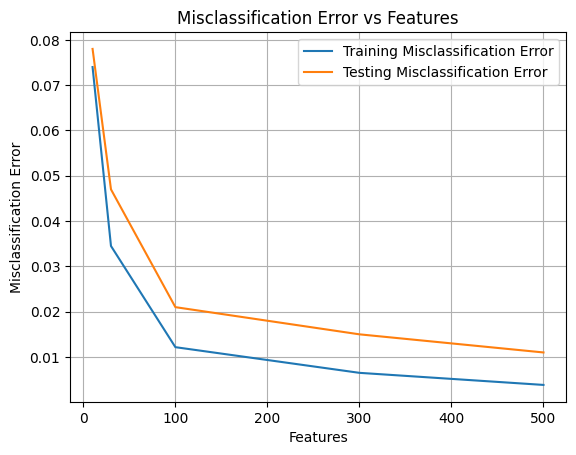

In [13]:
plt.plot(k,error_train,label='Training Misclassification Error')
plt.plot(k,error_test,label='Testing Misclassification Error')
plt.title('Misclassification Error vs Features')
plt.xlabel('Features')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend();

In [14]:
from IPython.display import HTML
d={'Features(K)':k,'Training Error':error_train,'Testing Error':error_test}
HTML(pd.DataFrame(d).to_html(index=False))

Features(K),Training Error,Testing Error
10,0.074000,0.078
30,0.034500,0.047
100,0.012167,0.021
300,0.006500,0.015
500,0.003833,0.011


In [15]:
w=np.zeros((p,1))
var=gisette_train_X
var_test=gisette_test_X
for i in range(n_iteration):
    XWT = var@w
    exp = np.exp(XWT)
    prob = exp/(1+exp)
    gradient = var.T@(gisette_train_label-prob)
    w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
    M=k[2]+(p-k[2])*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
    maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
    w=w[maxarg,:]
    var=var[:,maxarg]
    var_test=var_test[:,maxarg]

Pred_train = np.where((var@w)>0,1,0)
Pred_train_prob = np.exp(var@w)/(1+np.exp(var@w))
Pred_test =np.where((var_test[:,maxarg]@w)>0,1,0)
Pred_test_prob = np.exp(var_test[:,maxarg]@w)/(1+np.exp(var_test[:,maxarg]@w))

In [16]:
from sklearn.metrics import roc_curve
train_fp, train_tp, _ = roc_curve(gisette_train_label, Pred_train_prob)
test_fp, test_tp, _ = roc_curve(gisette_test_label, Pred_test_prob)

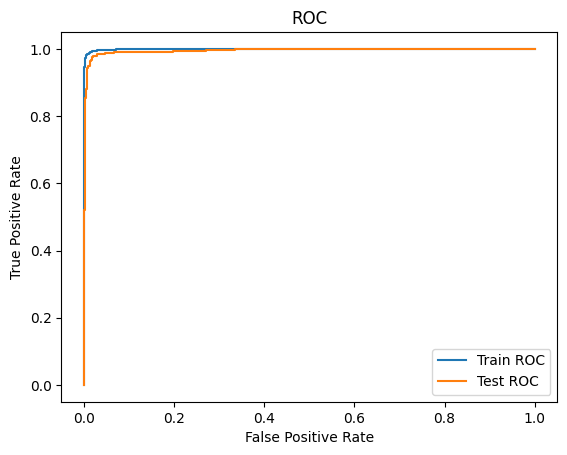

In [17]:
plt.plot(train_fp, train_tp, label='Train ROC')

plt.plot(test_fp, test_tp, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend();

In [18]:
from sklearn.metrics import roc_auc_score
auc_score_train = roc_auc_score(gisette_train_label, Pred_train)
auc_score_test = roc_auc_score(gisette_test_label, Pred_test)

In [19]:
from IPython.display import HTML
d={'Train/Test':['Train','Test'],'ROC AUC':[auc_score_train,auc_score_test]}
HTML(pd.DataFrame(d).to_html(index=False))

Train/Test,ROC AUC
Train,0.987833
Test,0.978000


**b) Repeat point a) on the dexter dataset. (2 points)**

In [20]:
dexter_train_X_path = Path(r'D:/Pycharm/Courses/STA5635/HW5/dexter/dexter_train.csv')
dexter_train_label_path = Path(r'D:/Pycharm/Courses/STA5635/HW5/dexter/dexter_train.labels')
dexter_test_X_path = Path(r'D:/Pycharm/Courses/STA5635/HW5/dexter/dexter_valid.csv')
dexter_test_label_path = Path(r'D:/Pycharm/Courses/STA5635/HW5/dexter/dexter_valid.labels')

In [21]:
dexter_train_X = pd.read_csv(dexter_train_X_path, delimiter=',', header=None)
dexter_train_label=pd.read_csv(dexter_train_label_path, delimiter=',', header=None)
dexter_test_X = pd.read_csv(dexter_test_X_path, delimiter=',', header=None)
dexter_test_label=pd.read_csv(dexter_test_label_path, delimiter=',', header=None)

In [22]:
# normalize the variables of the training set to have zero mean and standard deviation 1 
# Also removing the samples with std=0 which degenerate our scaling
sx=np.std(dexter_train_X,axis=0)
filt=sx>0
dexter_train_X=dexter_train_X.to_numpy()[:,filt]
dexter_test_X=dexter_test_X.to_numpy()[:,filt]
mx=np.mean(dexter_train_X,axis=0)
sx=np.std(dexter_train_X,axis=0)
dexter_train_X=(dexter_train_X-mx)/sx
dexter_test_X=(dexter_test_X-mx)/sx

In [23]:
dexter_train_X=np.c_[np.ones(dexter_train_X.shape[0]),dexter_train_X]
dexter_test_X=np.c_[np.ones(dexter_test_X.shape[0]),dexter_test_X]

In [24]:
dexter_train_label.loc[dexter_train_label[0]==-1] = 0
dexter_test_label.loc[dexter_test_label[0]==-1] = 0

In [25]:
dexter_train_label=dexter_train_label.to_numpy()
dexter_test_label=dexter_test_label.to_numpy()

In [26]:
learning_rate=1
k=[10,30,100,300,500]
s=0.0001
n_sample=len(dexter_train_X)
p=len(dexter_train_X[0])
n_iteration=300
w=np.zeros((p,1))
mu=200

In [27]:
var=dexter_train_X
w=np.zeros((p,1))
loss_list=[]
for i in range(n_iteration):
    XWT = var@w
    exp = np.exp(XWT)
    prob = exp/(1+exp)
    gradient = var.T@(dexter_train_label-prob)
    log_likelihood = (dexter_train_label.T@XWT)[0][0]- np.log(1+exp).sum()
    loss=-log_likelihood/n_sample+(s*(w.T@w)[0][0])
    loss_list.append(loss)
    w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
    M=k[1]+(p-k[1])*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
    maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
    w=w[maxarg,:]
    var=var[:,maxarg]

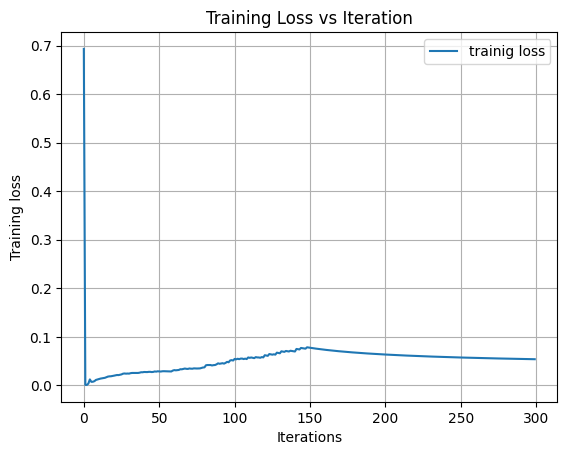

In [28]:
plt.plot(range(n_iteration),loss_list,label='trainig loss')
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Training Loss vs Iteration')
plt.grid()
plt.legend();

In [29]:
error_train=[]
error_test=[]
for j in k:
    var=dexter_train_X
    var_test=dexter_test_X
    w=np.zeros((p,1))
    for i in range(n_iteration):
        XWT = var@w
        exp = np.exp(XWT)
        prob = exp/(1+exp)
        gradient = var.T@(dexter_train_label-prob)
        w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
        M=j+(p-j)*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
        maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
        w=w[maxarg,:]
        var=var[:,maxarg]
        var_test=var_test[:,maxarg]

    Pred_train = np.where((var@w)>0,1,0)
    Pred_test =np.where((var_test@w)>0,1,0)
    error_train.append(1-accuracy_score(dexter_train_label,Pred_train))
    error_test.append(1-accuracy_score(dexter_test_label,Pred_test))

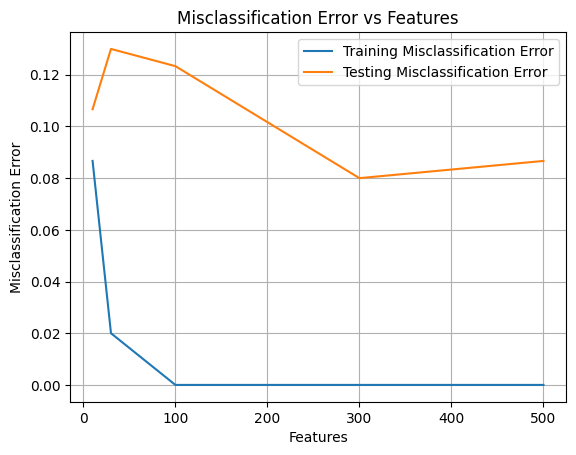

In [30]:
plt.plot(k,error_train,label='Training Misclassification Error')
plt.plot(k,error_test,label='Testing Misclassification Error')
plt.title('Misclassification Error vs Features')
plt.xlabel('Features')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend();

In [31]:
from IPython.display import HTML
d={'Features(K)':k,'Training Error':error_train,'Testing Error':error_test}
HTML(pd.DataFrame(d).to_html(index=False))

Features(K),Training Error,Testing Error
10,0.086667,0.106667
30,0.020000,0.130000
100,0.000000,0.123333
300,0.000000,0.080000
500,0.000000,0.086667


In [32]:
w=np.zeros((p,1))
var=dexter_train_X
var_test=dexter_test_X
for i in range(n_iteration):
    XWT = var@w
    exp = np.exp(XWT)
    prob = exp/(1+exp)
    gradient = var.T@(dexter_train_label-prob)
    w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
    M=k[2]+(p-k[2])*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
    maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
    w=w[maxarg,:]
    var=var[:,maxarg]
    var_test=var_test[:,maxarg]

Pred_train = np.where((var@w)>0,1,0)
Pred_train_prob = np.exp(var@w)/(1+np.exp(var@w))
Pred_test =np.where((var_test@w)>0,1,0)
Pred_test_prob = np.exp(var_test@w)/(1+np.exp(var_test@w))

In [33]:
from sklearn.metrics import roc_curve
train_fp, train_tp, _ = roc_curve(dexter_train_label, Pred_train_prob)
test_fp, test_tp, _ = roc_curve(dexter_test_label, Pred_test_prob)

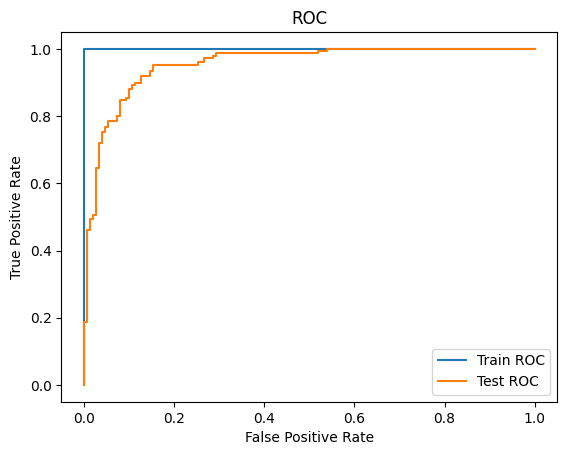

In [34]:
plt.plot(train_fp, train_tp, label='Train ROC')
plt.plot(test_fp, test_tp, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend();

In [35]:
from sklearn.metrics import roc_auc_score
auc_score_train = roc_auc_score(dexter_train_label, Pred_train)
auc_score_test = roc_auc_score(dexter_test_label, Pred_test)

In [36]:
from IPython.display import HTML
d={'Train/Test':['Train','Test'],'ROC AUC':[auc_score_train,auc_score_test]}
HTML(pd.DataFrame(d).to_html(index=False))

Train/Test,ROC AUC
Train,1.000000
Test,0.876667


**c) Repeat point a) on the madelon dataset. (3 points)**

In [37]:
madelon_train_X_path = Path('D:\Pycharm\Courses\STA5635\HW5\MADELON\madelon_train.data')
madelon_train_label_path = Path('D:\Pycharm\Courses\STA5635\HW5\MADELON\madelon_train.labels')
madelon_test_X_path = Path('D:\Pycharm\Courses\STA5635\HW5\MADELON\madelon_valid.data')
madelon_test_label_path = Path('D:\Pycharm\Courses\STA5635\HW5\MADELON\madelon_valid.labels')

In [38]:
madelon_train_X = pd.read_csv(madelon_train_X_path, delimiter=' ', header=None).drop(500,axis=1)
madelon_train_label = pd.read_csv(madelon_train_label_path, delimiter=' ', header=None)
madelon_test_X = pd.read_csv(madelon_test_X_path, delimiter=' ', header=None).drop(500,axis=1)
madelon_test_label = pd.read_csv(madelon_test_label_path, delimiter=' ', header=None)

In [39]:
# normalize the variables of the training set to have zero mean and standard deviation 1 
# Also removing the samples with std=0 which degenerate our scaling
sx=np.std(madelon_train_X,axis=0)
filt=sx>0
madelon_train_X=madelon_train_X.to_numpy()[:,filt]
madelon_test_X=madelon_test_X.to_numpy()[:,filt]
mx=np.mean(madelon_train_X,axis=0)
sx=np.std(madelon_train_X,axis=0)
madelon_train_X=(madelon_train_X-mx)/sx
madelon_test_X=(madelon_test_X-mx)/sx

In [40]:
madelon_train_X=np.c_[np.ones(madelon_train_X.shape[0]),madelon_train_X]
madelon_test_X=np.c_[np.ones(madelon_test_X.shape[0]),madelon_test_X]

In [41]:
madelon_train_label.loc[madelon_train_label[0]==-1] = 0
madelon_test_label.loc[madelon_test_label[0]==-1] = 0

In [42]:
madelon_train_label=madelon_train_label.to_numpy()
madelon_test_label=madelon_test_label.to_numpy()

In [43]:
learning_rate=1
k=[10,30,100,300,500]
s=0.0001
n_sample=len(madelon_train_X)
p=len(madelon_train_X[0])
n_iteration=300
w=np.zeros((p,1))
mu=200

In [44]:
var=madelon_train_X
w=np.zeros((p,1))
loss_list=[]
for i in range(n_iteration):
    XWT = var@w
    exp = np.exp(XWT)
    prob = exp/(1+exp)
    gradient = var.T@(madelon_train_label-prob)
    log_likelihood = (madelon_train_label.T@XWT)[0][0]- np.log(1+exp).sum()
    loss=-log_likelihood/n_sample+(s*(w.T@w)[0][0])
    loss_list.append(loss)
    w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
    M=k[1]+(p-k[1])*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
    maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
    w=w[maxarg,:]
    var=var[:,maxarg]    

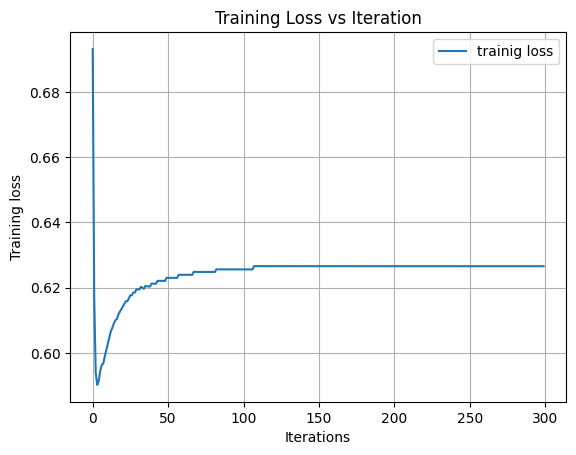

In [45]:
plt.plot(range(n_iteration),loss_list,label='trainig loss')
plt.xlabel('Iterations')
plt.ylabel('Training loss')
plt.title('Training Loss vs Iteration')
plt.grid()
plt.legend();

In [46]:
error_train=[]
error_test=[]
for j in k:
    var=madelon_train_X
    w=np.zeros((p,1))
    var_test=madelon_test_X
    for i in range(n_iteration):
        XWT = var@w
        exp = np.exp(XWT)
        prob = exp/(1+exp)
        gradient = var.T@(madelon_train_label-prob)
        w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
        M=j+(p-j)*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
        maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
        w=w[maxarg,:]
        var=var[:,maxarg]
        var_test=var_test[:,maxarg]

    Pred_train = np.where((var@w)>0,1,0)
    Pred_test =np.where((var_test@w)>0,1,0)
    error_train.append(1-accuracy_score(madelon_train_label,Pred_train))
    error_test.append(1-accuracy_score(madelon_test_label,Pred_test))

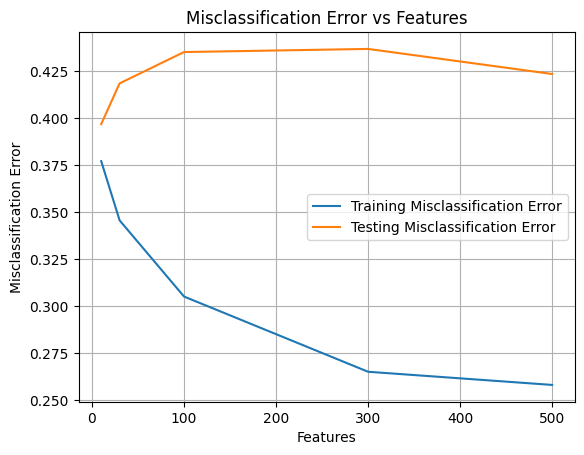

In [47]:
plt.plot(k,error_train,label='Training Misclassification Error')
plt.plot(k,error_test,label='Testing Misclassification Error')
plt.title('Misclassification Error vs Features')
plt.xlabel('Features')
plt.ylabel('Misclassification Error')
plt.grid()
plt.legend();

In [48]:
from IPython.display import HTML
d={'Features(K)':k,'Training Error':error_train,'Testing Error':error_test}
HTML(pd.DataFrame(d).to_html(index=False))

Features(K),Training Error,Testing Error
10,0.3770,0.396667
30,0.3455,0.418333
100,0.3050,0.435000
300,0.2650,0.436667
500,0.2580,0.423333


In [49]:
w=np.zeros((p,1))
var=madelon_train_X
var_test=madelon_test_X
for i in range(n_iteration):
    XWT = var@w
    exp = np.exp(XWT)
    prob = exp/(1+exp)
    gradient = var.T@(madelon_train_label-prob)
    w = w - 2*s*learning_rate*w +(learning_rate/n_sample)*gradient
    M=k[2]+(p-k[2])*max(0,(n_iteration-(2*i))/((2*i*mu)+n_iteration))
    maxarg=np.argsort(-(np.abs(w*w)),axis=None)[:int(M)]
    w=w[maxarg,:]
    var=var[:,maxarg]
    var_test=var_test[:,maxarg]

Pred_train = np.where((var@w)>0,1,0)
Pred_train_prob = np.exp(var@w)/(1+np.exp(var@w))
Pred_test =np.where((var_test@w)>0,1,0)
Pred_test_prob = np.exp(var_test@w)/(1+np.exp(var_test@w))

In [50]:
from sklearn.metrics import roc_curve
train_fp, train_tp, _ = roc_curve(madelon_train_label, Pred_train_prob)
test_fp, test_tp, _ = roc_curve(madelon_test_label, Pred_test_prob)

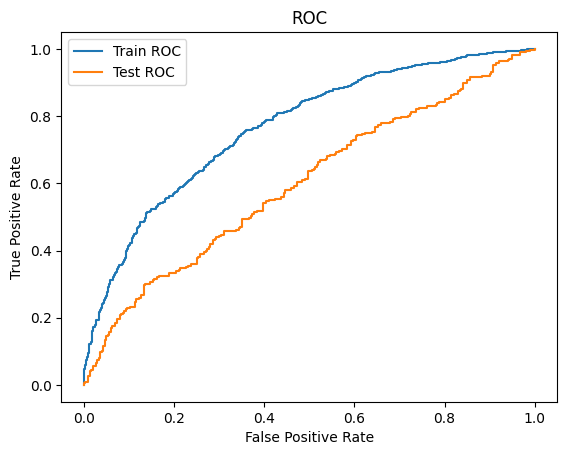

In [51]:
plt.plot(train_fp, train_tp, label='Train ROC')
plt.plot(test_fp, test_tp, label='Test ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend();

In [52]:
from sklearn.metrics import roc_auc_score
auc_score_train = roc_auc_score(madelon_train_label, Pred_train)
auc_score_test = roc_auc_score(madelon_test_label, Pred_test)

In [53]:
from IPython.display import HTML
d={'Train/Test':['Train','Test'],'ROC AUC':[auc_score_train,auc_score_test]}
HTML(pd.DataFrame(d).to_html(index=False))

Train/Test,ROC AUC
Train,0.695
Test,0.565
